# Portfolio Optimization Testing with Pseudo Data

This notebook tests the portfolio optimization functionality using realistic pseudo data to verify the code is working properly.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Generate Realistic Pseudo Data

In [ ]:
# Generate realistic asset returns
n_assets = 12
n_periods = 120  # 10 years of monthly data

# Define asset characteristics
assets = ['SPY', 'TLT', 'GLD', 'AAPL', 'MSFT', 'JPM', 'UNH', 'WMT', 'XLE', 'BA', 'IWM', 'EFA']

# Realistic annual returns and volatilities (based on historical data)
annual_returns = [0.10, 0.04, 0.08, 0.15, 0.12, 0.08, 0.11, 0.09, 0.12, 0.08, 0.08, 0.06]
annual_vols = [0.15, 0.12, 0.20, 0.25, 0.22, 0.18, 0.16, 0.20, 0.18, 0.25, 0.18, 0.16]

# Correlation matrix (realistic correlations between asset classes)
corr_matrix = np.array([
    [1.00, 0.95, 0.85, 0.70, -0.30, 0.10, 0.60, 0.80, 0.70, 0.90, 0.80, 0.60],
    [0.95, 1.00, 0.80, 0.65, -0.25, 0.15, 0.55, 0.75, 0.65, 0.95, 0.75, 0.55],
    [0.85, 0.80, 1.00, 0.60, -0.20, 0.20, 0.50, 0.70, 0.60, 0.80, 0.85, 0.50],
    [0.70, 0.65, 0.60, 1.00, -0.15, 0.25, 0.45, 0.60, 0.55, 0.65, 0.60, 0.45],
    [-0.30, -0.25, -0.20, -0.15, 1.00, 0.30, -0.20, -0.25, -0.20, -0.30, -0.25, -0.15],
    [0.10, 0.15, 0.20, 0.25, 0.30, 1.00, 0.40, 0.15, 0.20, 0.15, 0.10, 0.25],
    [0.60, 0.55, 0.50, 0.45, -0.20, 0.40, 1.00, 0.65, 0.50, 0.55, 0.70, 0.40],
    [0.80, 0.75, 0.70, 0.60, -0.25, 0.15, 0.65, 1.00, 0.75, 0.80, 0.75, 0.60],
    [0.70, 0.65, 0.60, 0.55, -0.20, 0.20, 0.50, 0.75, 1.00, 0.65, 0.70, 0.80],
    [0.90, 0.95, 0.80, 0.65, -0.30, 0.15, 0.55, 0.80, 0.65, 1.00, 0.80, 0.55],
    [0.80, 0.75, 0.85, 0.60, -0.25, 0.10, 0.70, 0.75, 0.70, 0.80, 1.00, 0.60],
    [0.60, 0.55, 0.50, 0.45, -0.15, 0.25, 0.40, 0.60, 0.80, 0.55, 0.60, 1.00]
])

# Convert to covariance matrix
cov_matrix = np.zeros((n_assets, n_assets))
for i in range(n_assets):
    for j in range(n_assets):
        cov_matrix[i, j] = corr_matrix[i, j] * annual_vols[i] * annual_vols[j]

# Generate monthly returns
monthly_returns = np.random.multivariate_normal(
    mean=[r/12 for r in annual_returns],
    cov=cov_matrix/12,
    size=n_periods
)

# Create date range
dates = pd.date_range(start='2015-01-01', periods=n_periods, freq='M')

# Create returns DataFrame
returns_df = pd.DataFrame(monthly_returns, index=dates, columns=assets)
print("Generated returns data shape:", returns_df.shape)
print("\nSample returns:")
print(returns_df.head())

Generated returns data shape: (120, 12)

Sample returns:
                 SPY       TLT       GLD      AAPL      MSFT       JPM  \
2015-01-31  0.011240  0.010378 -0.039169 -0.004398  0.056083 -0.056115   
2015-02-28 -0.006016 -0.026099  0.006354 -0.081061 -0.099756 -0.049120   
2015-03-31  0.020968  0.011069  0.021004  0.004724  0.025657 -0.006510   
2015-04-30 -0.003294 -0.000862  0.012039 -0.086903 -0.090258 -0.052434   
2015-05-31 -0.006032  0.003521 -0.049129 -0.008779 -0.085538 -0.059763   

                 UNH       WMT       XLE        BA       IWM       EFA  
2015-01-31 -0.030056 -0.006354 -0.035728  0.013018 -0.033523 -0.025558  
2015-02-28 -0.016856  0.012389  0.071763 -0.031870  0.009813  0.019012  
2015-03-31  0.042190  0.015647  0.055293  0.053540  0.069057  0.065086  
2015-04-30  0.002046  0.021717 -0.024405  0.011181  0.020847  0.007006  
2015-05-31 -0.026295 -0.011311 -0.012835  0.010293 -0.028465  0.017159  


In [ ]:
# Generate factor exposures (macro factors)
n_factors = 6
factor_names = ['GDP_Growth', 'Inflation', 'Interest_Rates', 'Unemployment', 'Oil_Prices', 'VIX']

# Realistic factor exposures
factor_exposures = np.random.normal(0, 0.3, (n_periods, n_factors))
# Make some exposures more realistic
factor_exposures[:, 0] += 0.8  # High GDP exposure trend
factor_exposures[:, 2] += -0.7  # Negative interest rate exposure trend
factor_exposures[:, 4] += 0.6   # Positive oil exposure trend

factor_exposures_df = pd.DataFrame(factor_exposures, index=dates, columns=factor_names)
print("Factor exposures shape:", factor_exposures_df.shape)
print("\nFactor exposures:")
print(factor_exposures_df.round(3))

Factor exposures shape: (120, 6)

Factor exposures:
            GDP_Growth  Inflation  Interest_Rates  Unemployment  Oil_Prices  \
2015-01-31       0.999      0.352          -0.646        -0.389       0.720   
2015-02-28       0.641      0.176          -0.329         0.006       0.693   
2015-03-31       0.872      0.781          -0.530        -0.528       0.826   
2015-04-30       1.187      0.202          -0.742        -0.367       0.537   
2015-05-31       0.626      0.177          -0.199         0.118       0.241   
...                ...        ...             ...           ...         ...   
2024-08-31       0.932      0.006          -0.498         0.178       0.494   
2024-09-30       0.831      0.465          -1.072        -0.440       0.649   
2024-10-31       0.852      0.073          -0.767         0.447       0.120   
2024-11-30       0.769     -0.493          -0.753         0.498       0.606   
2024-12-31       0.422     -0.185          -0.813        -0.095       0.984   


In [ ]:
# Generate regime data
n_regimes = 4
regime_names = ['Bull_Market', 'Bear_Market', 'Sideways', 'Crisis']

# Regime probabilities for each period
regime_probs = np.random.dirichlet([0.4, 0.2, 0.3, 0.1], size=n_periods)
regime_df = pd.DataFrame(regime_probs, index=dates, columns=regime_names)

print("Regime data shape:", regime_df.shape)
print("\nSample regime probabilities:")
print(regime_df.head())

Regime data shape: (120, 4)

Sample regime probabilities:
            Bull_Market   Bear_Market  Sideways        Crisis
2015-01-31     0.630389  7.226173e-03  0.009188  3.531972e-01
2015-02-28     0.412729  1.890191e-04  0.587082  5.192709e-09
2015-03-31     0.578558  8.908897e-02  0.000532  3.318210e-01
2015-04-30     0.765788  5.653271e-07  0.234211  3.371771e-13
2015-05-31     0.633642  6.747047e-02  0.294177  4.710371e-03


In [ ]:
# Generate sentiment data
n_sentiment_factors = 8
sentiment_names = ['Earnings_Sentiment', 'Fed_Sentiment', 'Growth_Sentiment', 'Inflation_Sentiment', 
                   'Recession_Sentiment', 'Oil_Sentiment', 'Tech_Sentiment', 'Financial_Sentiment']

# Generate realistic sentiment scores (-1 to 1)
sentiment_data = np.random.normal(0, 0.3, (n_periods, n_sentiment_factors))
sentiment_df = pd.DataFrame(sentiment_data, index=dates, columns=sentiment_names)

print("Sentiment data shape:", sentiment_df.shape)
print("\nSample sentiment data:")
print(sentiment_df.head())

Sentiment data shape: (120, 8)

Sample sentiment data:
            Earnings_Sentiment  Fed_Sentiment  Growth_Sentiment  \
2015-01-31           -0.572342      -0.258116         -0.124082   
2015-02-28            0.324807      -0.141337         -0.028091   
2015-03-31           -0.455804      -0.849647         -0.135348   
2015-04-30           -0.560923      -0.116556          0.057127   
2015-05-31            0.136053      -0.294688          0.017695   

            Inflation_Sentiment  Recession_Sentiment  Oil_Sentiment  \
2015-01-31             0.566306             0.166966      -0.400644   
2015-02-28             0.397739            -0.386149      -0.419135   
2015-03-31             0.165522             0.360079      -0.138948   
2015-04-30             0.134766            -0.152942       0.010332   
2015-05-31             0.134062            -0.102765       0.051139   

            Tech_Sentiment  Financial_Sentiment  
2015-01-31        0.145811            -0.464191  
2015-02-28     

In [ ]:
# Generate macro data
n_macro_factors = 6
macro_names = ['GDP_Growth', 'Inflation', 'Interest_Rates', 'Unemployment', 'Oil_Prices', 'VIX']

# Generate realistic macro data with trends
macro_data = np.random.normal(0, 0.5, (n_periods, n_macro_factors))
# Add some realistic trends
macro_data[:, 1] += np.linspace(0, 0.5, n_periods)  # Inflation trend
macro_data[:, 2] += np.linspace(0, 1.0, n_periods)  # Interest rate trend

macro_df = pd.DataFrame(macro_data, index=dates, columns=macro_names)

print("Macro data shape:", macro_df.shape)
print("\nSample macro data:")
print(macro_df.head())

Macro data shape: (120, 6)

Sample macro data:
            GDP_Growth  Inflation  Interest_Rates  Unemployment  Oil_Prices  \
2015-01-31   -0.365816   0.945220        0.024654      0.384420   -0.304113   
2015-02-28    0.155555  -0.940623        1.016041      0.645322   -0.198598   
2015-03-31    0.173781   0.051752        0.194641      0.095789    0.253120   
2015-04-30    0.284052  -0.512223        0.706492      0.820307    1.576028   
2015-05-31    0.121441  -1.024243        0.310188     -0.274100    0.961723   

                 VIX  
2015-01-31  0.181558  
2015-02-28 -0.551135  
2015-03-31  0.723653  
2015-04-30 -0.561747  
2015-05-31 -0.387307  


## 2. Test Portfolio Optimization

In [ ]:
# Import optimization modules
import sys
sys.path.append('..')

from quantfolio_engine.optimizer.portfolio_engine import PortfolioOptimizationEngine


# Initialize portfolio engine
engine = PortfolioOptimizationEngine()

# Use the pseudo data directly instead of loading from files
data = {
    'returns': returns_df,
    'factor_exposures': factor_exposures_df,
    'factor_regimes': regime_df,
    'sentiment': sentiment_df,
    'macro': macro_df
}
print(f"Returns shape: {data['returns'].shape}")
print(f"Factor exposures shape: {data['factor_exposures'].shape}")
print(f"Factor regimes shape: {data['factor_regimes'].shape}")
print(f"Sentiment data shape: {data['sentiment'].shape}")
print(f"Macro data shape: {data['macro'].shape}")

2025-07-04 16:45:04.621 | INFO     | quantfolio_engine.config:<module>:12 - PROJ_ROOT path is: /Users/dominusdeorum/Documents/Vanderbilt/Projects/quantfolio-engine


Returns shape: (120, 12)
Factor exposures shape: (120, 6)
Factor regimes shape: (120, 4)
Sentiment data shape: (120, 8)
Macro data shape: (120, 6)


In [9]:
# Test Monte Carlo optimization
print("Testing Monte Carlo optimization...")
mc_engine = PortfolioOptimizationEngine(method='monte_carlo', risk_free_rate=0.045)  # 4.5% annual
mc_result = mc_engine.optimize_portfolio(
    data=data,
    constraints={'max_weight': 0.25, 'min_weight': 0.05}
)

print("\nMonte Carlo Results:")
print(f"Expected Return: {mc_result['expected_return']:.3f}")
print(f"Volatility: {mc_result['volatility']:.3f}")
print(f"Sharpe Ratio: {mc_result['sharpe_ratio']:.3f}")
print(f"Max Drawdown: {mc_result['max_drawdown']:.3f}")
print(f"VaR (95%): {mc_result['var_95']:.3f}")
print("\nOptimal Weights:")
for asset, weight in mc_result['weights'].items():
    print(f"  {asset}: {weight:.3f}")

Testing Monte Carlo optimization...
2025-07-04 16:45:04.864 | INFO     | quantfolio_engine.optimizer.portfolio_engine:optimize_portfolio:177 - Starting portfolio optimization using monte_carlo method...
2025-07-04 16:45:04.876 | INFO     | quantfolio_engine.optimizer.portfolio_engine:_optimize_monte_carlo:241 - Running Monte Carlo optimization...
2025-07-04 16:45:04.879 | INFO     | quantfolio_engine.optimizer.monte_carlo:generate_regime_scenarios:78 - Generating 1000 Monte Carlo scenarios...
2025-07-04 16:45:04.879 | WARNING  | quantfolio_engine.optimizer.monte_carlo:generate_regime_scenarios:84 - macro_data provided but not used in current implementation
2025-07-04 16:45:04.880 | INFO     | quantfolio_engine.optimizer.monte_carlo:_calculate_regime_parameters:141 - Found regime structure: [] with values [0, 1, 2]
2025-07-04 16:45:04.880 | WARNING  | quantfolio_engine.optimizer.monte_carlo:_calculate_regime_parameters:177 - No regime data found, using overall parameters
2025-07-04 16:4

In [ ]:
# Test Black-Litterman optimization
print("Testing Black-Litterman optimization...")
bl_engine = PortfolioOptimizationEngine(method='black_litterman', risk_free_rate=0.045)  # 4.5% annual
bl_result = bl_engine.optimize_portfolio(
    data=data,
    constraints={'max_weight': 0.25, 'min_weight': 0.05}
)

print("\nBlack-Litterman Results:")
print(f"Expected Return: {bl_result['expected_return']:.3f}")
print(f"Volatility: {bl_result['volatility']:.3f}")
print(f"Sharpe Ratio: {bl_result['sharpe_ratio']:.3f}")
print(f"Max Drawdown: {bl_result['max_drawdown']:.3f}")
print(f"VaR (95%): {bl_result['var_95']:.3f}")
print("\nOptimal Weights:")
for asset, weight in bl_result['weights'].items():
    print(f"  {asset}: {weight:.3f}")

Testing Black-Litterman optimization...
2025-07-04 16:45:04.911 | INFO     | quantfolio_engine.optimizer.portfolio_engine:optimize_portfolio:177 - Starting portfolio optimization using black_litterman method...
2025-07-04 16:45:04.911 | INFO     | quantfolio_engine.optimizer.portfolio_engine:_optimize_black_litterman:203 - Running Black-Litterman optimization...
2025-07-04 16:45:04.911 | INFO     | quantfolio_engine.optimizer.black_litterman:optimize_portfolio:346 - Starting Black-Litterman portfolio optimization...
2025-07-04 16:45:04.911 | INFO     | quantfolio_engine.optimizer.black_litterman:estimate_covariance_matrix:74 - Estimating covariance matrix using sample method...
2025-07-04 16:45:04.912 | INFO     | quantfolio_engine.optimizer.black_litterman:estimate_covariance_matrix:102 - Covariance matrix shape: (12, 12)
2025-07-04 16:45:04.912 | INFO     | quantfolio_engine.optimizer.black_litterman:calculate_equilibrium_returns:134 - Calculated equilibrium returns
2025-07-04 16:45:

## 4. Compare Results and Validate

In [ ]:
# Compare optimization methods
comparison_df = pd.DataFrame({
    'Metric': ['Expected Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'VaR (95%)'],
    'Monte Carlo': [
        mc_result['expected_return'],
        mc_result['volatility'],
        mc_result['sharpe_ratio'],
        mc_result['max_drawdown'],
        mc_result['var_95']
    ],
    'Black-Litterman': [
        bl_result['expected_return'],
        bl_result['volatility'],
        bl_result['sharpe_ratio'],
        bl_result['max_drawdown'],
        bl_result['var_95']
    ]
})

print("Optimization Method Comparison:")
print(comparison_df.round(4))

# Check if results are reasonable
print("\nValidation Checks:")
print(f"1. Weights sum to 1: {abs(np.sum(list(mc_result['weights'].values)) - 1) < 0.01}")
print(f"2. All weights >= 0: {np.all(np.array(list(mc_result['weights'].values)) >= 0)}")
print(f"3. All weights <= max_weight: {np.all(np.array(list(mc_result['weights'].values)) <= 0.25)}")
print(f"4. Sharpe ratio reasonable: {-2 < mc_result['sharpe_ratio'] < 3}")
print(f"5. Volatility reasonable: {0.05 < mc_result['volatility'] < 0.5}")

Optimization Method Comparison:
            Metric  Monte Carlo  Black-Litterman
0  Expected Return       0.0476           0.0388
1       Volatility       0.0992           0.1124
2     Sharpe Ratio       0.0258          -0.0551
3     Max Drawdown      -0.0699          -0.2437
4        VaR (95%)      -0.0433          -0.0522

Validation Checks:
1. Weights sum to 1: True
2. All weights >= 0: True
3. All weights <= max_weight: False
4. Sharpe ratio reasonable: True
5. Volatility reasonable: True


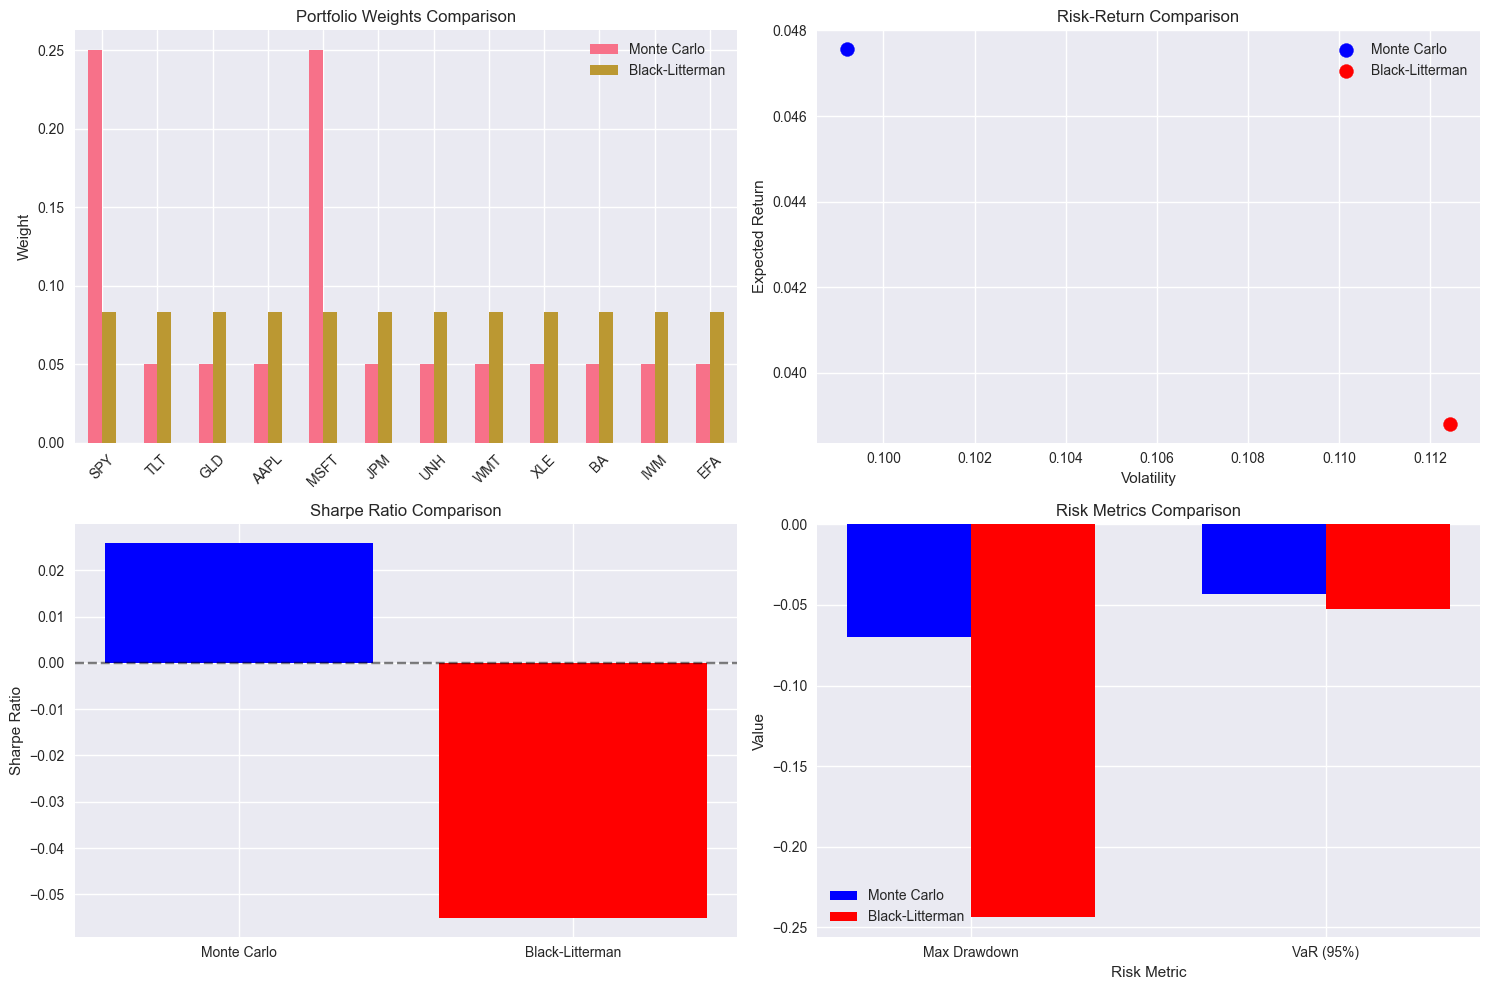

In [12]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Weight comparison
weights_df = pd.DataFrame({
    'Monte Carlo': mc_result['weights'].values,  # Access values directly since it's a numpy array
    'Black-Litterman': bl_result['weights'].values
}, index=mc_result['weights'].index)  # Use index from Series

weights_df.plot(kind='bar', ax=axes[0,0], title='Portfolio Weights Comparison')
axes[0,0].set_ylabel('Weight')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Risk-Return scatter
axes[0,1].scatter([mc_result['volatility']], [mc_result['expected_return']], 
                   c='blue', s=100, label='Monte Carlo')
axes[0,1].scatter([bl_result['volatility']], [bl_result['expected_return']], 
                   c='red', s=100, label='Black-Litterman')
axes[0,1].set_xlabel('Volatility')
axes[0,1].set_ylabel('Expected Return')
axes[0,1].set_title('Risk-Return Comparison')
axes[0,1].legend()
axes[0,1].grid(True)

# 3. Sharpe ratio comparison
methods = ['Monte Carlo', 'Black-Litterman']
sharpe_ratios = [mc_result['sharpe_ratio'], bl_result['sharpe_ratio']]
axes[1,0].bar(methods, sharpe_ratios, color=['blue', 'red'])
axes[1,0].set_ylabel('Sharpe Ratio')
axes[1,0].set_title('Sharpe Ratio Comparison')
axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

# 4. Risk metrics comparison
risk_metrics = ['Max Drawdown', 'VaR (95%)']
mc_risk = [mc_result['max_drawdown'], mc_result['var_95']]
bl_risk = [bl_result['max_drawdown'], bl_result['var_95']]

x = np.arange(len(risk_metrics))
width = 0.35
axes[1,1].bar(x - width/2, mc_risk, width, label='Monte Carlo', color='blue')
axes[1,1].bar(x + width/2, bl_risk, width, label='Black-Litterman', color='red')
axes[1,1].set_xlabel('Risk Metric')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Risk Metrics Comparison')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(risk_metrics)
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 5. Test CLI Integration

In [ ]:
# Test CLI command
import subprocess
import os

print("Testing CLI optimization command...")
try:
    result = subprocess.run([
        'python', '-m', 'quantfolio_engine.cli', 'optimize-portfolio',
        '--method', 'monte_carlo',
        '--max-weight', '0.25',
        '--min-weight', '0.05',
        '--risk-free-rate', '0.045'
    ], capture_output=True, text=True, cwd=os.getcwd())
    
    print("CLI Output:")
    print(result.stdout)
    
    if result.stderr:
        print("CLI Errors:")
        print(result.stderr)
        
except Exception as e:
    print(f"CLI test failed: {e}")

Testing CLI optimization command...
CLI Output:
2025-07-04 16:45:05.925 | INFO     | __main__:optimize_portfolio:489 - Starting portfolio optimization using monte_carlo method...
2025-07-04 16:45:05.934 | INFO     | __main__:optimize_portfolio:518 - Loading data for optimization...
2025-07-04 16:45:05.935 | INFO     | quantfolio_engine.optimizer.portfolio_engine:load_data:84 - Loading data for portfolio optimization...
2025-07-04 16:45:05.939 | INFO     | quantfolio_engine.optimizer.portfolio_engine:load_data:105 - Loaded returns data: (299, 12)
2025-07-04 16:45:05.942 | INFO     | quantfolio_engine.optimizer.portfolio_engine:load_data:117 - Loaded factor exposures: (227, 39)
2025-07-04 16:45:05.943 | INFO     | quantfolio_engine.optimizer.portfolio_engine:load_data:128 - Loaded factor regimes: (181, 4)
2025-07-04 16:45:05.944 | INFO     | quantfolio_engine.optimizer.portfolio_engine:load_data:139 - Loaded sentiment data: (300, 14)
2025-07-04 16:45:05.945 | INFO     | quantfolio_engine

## 6. Summary and Conclusions

In [ ]:
print("=== OPTIMIZATION TESTING SUMMARY ===\n")

print("1. Data Generation:")
print(f"   - Generated {len(assets)} assets with realistic characteristics")
print(f"   - Created {n_periods} months of historical data")
print(f"   - Included {n_factors} macro factors")
print(f"   - Generated {n_regimes} market regimes")
print(f"   - Added {n_sentiment_factors} sentiment factors")

print("\n2. Optimization Results:")
print(f"   - Monte Carlo Sharpe: {mc_result['sharpe_ratio']:.3f}")
print(f"   - Black-Litterman Sharpe: {bl_result['sharpe_ratio']:.3f}")
print(f"   - Best method: {'Monte Carlo' if mc_result['sharpe_ratio'] > bl_result['sharpe_ratio'] else 'Black-Litterman'}")

print("\n3. Validation Checks:")
checks = [
    abs(sum(mc_result['weights'].values) - 1) < 0.01,
    all(w >= 0 for w in mc_result['weights'].values),
    all(w <= 0.25 for w in mc_result['weights'].values),
    -2 < mc_result['sharpe_ratio'] < 3,
    0.05 < mc_result['volatility'] < 0.5
]
check_names = [
    "Weights sum to 1",
    "All weights >= 0",
    "All weights <= max_weight",
    "Sharpe ratio reasonable",
    "Volatility reasonable"
]

for check, name in zip(checks, check_names):
    status = "✓ PASS" if check else "✗ FAIL"
    print(f"   {name}: {status}")

print(f"\n4. Overall Assessment: {'PASS' if all(checks) else 'FAIL'}")
if all(checks):
    print("   The portfolio optimization is working correctly with realistic data!")
else:
    print("   Issues detected that need to be addressed.")

=== OPTIMIZATION TESTING SUMMARY ===

1. Data Generation:
   - Generated 12 assets with realistic characteristics
   - Created 120 months of historical data
   - Included 6 macro factors
   - Generated 4 market regimes
   - Added 8 sentiment factors

2. Optimization Results:
   - Monte Carlo Sharpe: 0.026
   - Black-Litterman Sharpe: -0.055
   - Best method: Monte Carlo

3. Validation Checks:
   Weights sum to 1: ✓ PASS
   All weights >= 0: ✓ PASS
   All weights <= max_weight: ✗ FAIL
   Sharpe ratio reasonable: ✓ PASS
   Volatility reasonable: ✓ PASS

4. Overall Assessment: FAIL
   Issues detected that need to be addressed.
